In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.io import loadmat, savemat
from scipy import signal

In [3]:
mt_file = loadmat('data/gestures_4d_full.mat')

In [4]:
mt_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data'])

In [5]:
labels = mt_file['labels'][0]
labels

array([ 0,  1,  2, ..., 27, 42, 45], dtype=int64)

In [6]:
mt_file['data'].shape

(7420, 120, 67, 3)

In [7]:
data_4d = mt_file['data'][::,::,::]
data = np.mean(np.mean(data_4d, axis=-1), axis=-1)
data.shape

(7420, 120)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data.T).T
data.shape

(7420, 120)

### TODO: Remove outliers yourself !!!

In [9]:
clean_data = data
clean_labels = labels

### STFT

In [10]:
sig = clean_data[206]
print(sig.shape)
f, t, Zxx = signal.stft(signal.medfilt(sig,5),
                        fs=30,
                        nperseg=16,
                        noverlap=15,
                        boundary='constant')
print(Zxx.shape)
print(f)

(120,)
(9, 121)
[ 0.     1.875  3.75   5.625  7.5    9.375 11.25  13.125 15.   ]


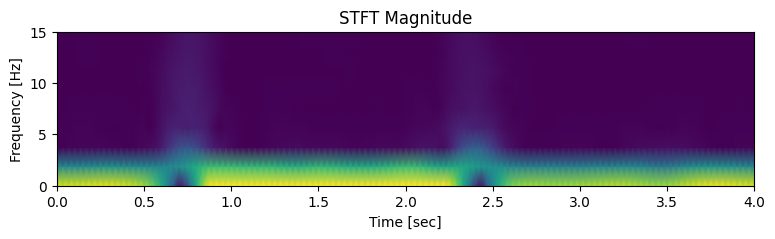

In [11]:
plt.figure(figsize=(9,2))
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.max(sig), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

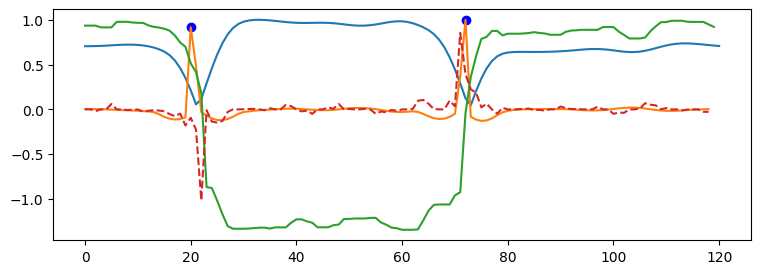

In [12]:
plt.figure(figsize=(9,3))
mean_spec = np.mean(np.abs(Zxx)[:1,], axis=0)
mean_spec = mean_spec/np.max(mean_spec)

diff_spec = np.diff(mean_spec,2)
diff_spec = diff_spec/np.max(diff_spec)

# peaks
peaks2, _ = signal.find_peaks(diff_spec, prominence=0.5)   
plt.plot(peaks2, diff_spec[peaks2], "ob")

plt.plot(mean_spec)
plt.plot(diff_spec)
plt.plot(signal.medfilt(sig,5)/np.max(sig))
plt.plot(np.diff(signal.medfilt(sig,5)), '--')
plt.show()

Num of trials for which first step is outside [10:60] time stamp bound = 134, 1.81%


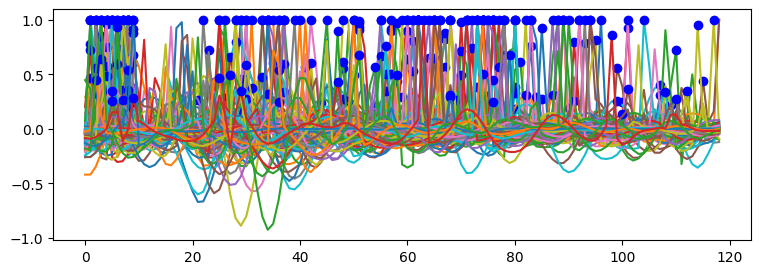

In [13]:
cnt = 0

plt.figure(figsize=(9,3))

for sig in clean_data:
    f, t, Zxx = signal.stft(signal.medfilt(sig,3),
                        fs=30,
                        nperseg=16,
                        noverlap=15,
                        boundary='constant')
    
    mean_spec = np.mean(np.abs(Zxx)[:1,], axis=0)
    mean_spec = mean_spec/np.max(mean_spec)

    diff_spec = np.diff(mean_spec,2)
    diff_spec = diff_spec/np.max(diff_spec)
    
    peaks2, _ = signal.find_peaks(diff_spec, prominence=0.3, distance=20) #prominence=0.3,   
    
    if peaks2[0]<10 or peaks2[0]>60:
        cnt += 1
        plt.plot(diff_spec)#signal.medfilt(sig,3))
        plt.plot(peaks2, diff_spec[peaks2], "ob")


prct = round(100*cnt/len(clean_data), 2)
print(f"Num of trials for which first step is outside [10:60] time stamp bound = {cnt}, {prct}%")
plt.show()

### Getting gesture start time

In [14]:
def get_first_step_idx(sig):
    f, t, Zxx = signal.stft(signal.medfilt(sig,3),
                        fs=30,
                        nperseg=16,
                        noverlap=15,
                        boundary='constant')
    
    mean_spec = np.mean(np.abs(Zxx)[:1,], axis=0)
    mean_spec = mean_spec/np.max(mean_spec)

    diff_spec = np.diff(mean_spec,2)
    diff_spec = diff_spec/np.max(diff_spec)
    
    peaks2, _ = signal.find_peaks(diff_spec, prominence=0.3, distance=20)
    
    return peaks2[0]

In [15]:
def sort_by(input_array, sort_values):
    output = [x for _, x in sorted(zip(sort_values, input_array),key=lambda pair: pair[0])]
    return np.array(output)

sort_by(input_array=[2,3,4], sort_values=[3,1,2])

array([3, 4, 2])

#### getting indexes of first encountered step-change in the signal

In [17]:
first_step_idx = []
last_step_idx = []
for sig in clean_data:
    first_idx = get_first_step_idx(sig)
    last_idx = get_first_step_idx(sig[::-1])
    
    first_step_idx.append(first_idx)
    last_step_idx.append(120-last_idx)    

74


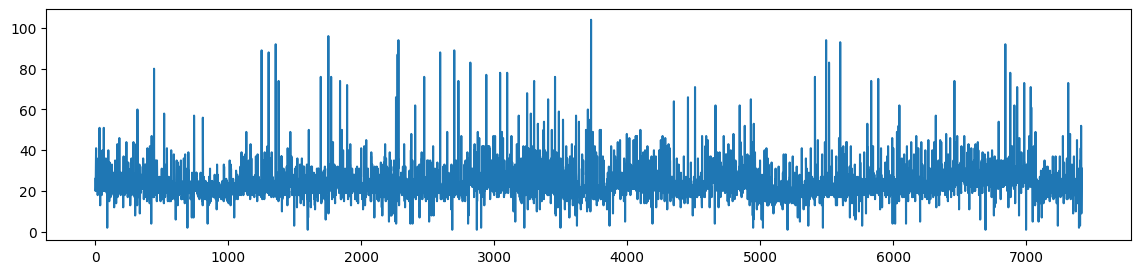

In [22]:
print(np.sum(np.array(first_step_idx)>50))
plt.figure(figsize=(14,3))
plt.plot(first_step_idx)
plt.show()

386


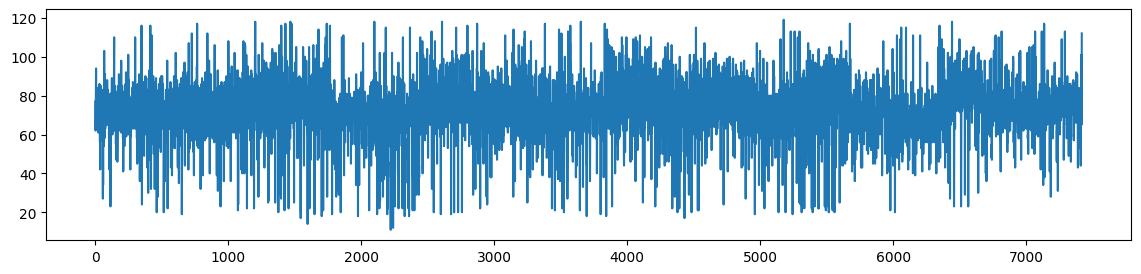

In [26]:
print(np.sum(np.array(last_step_idx)<50))
plt.figure(figsize=(14,3))
plt.plot(last_step_idx)
plt.show()

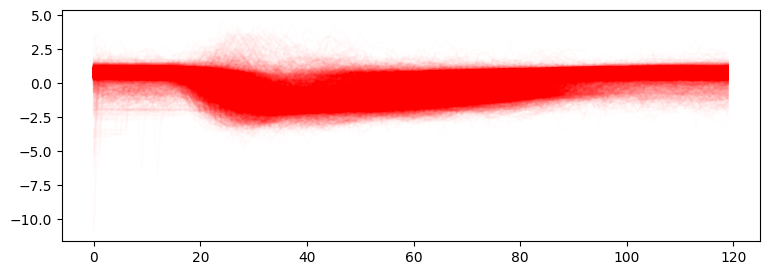

In [28]:
plt.figure(figsize=(9,3))
for sss in clean_data:
    plt.plot(sss, color='r', alpha=0.01)
plt.show()

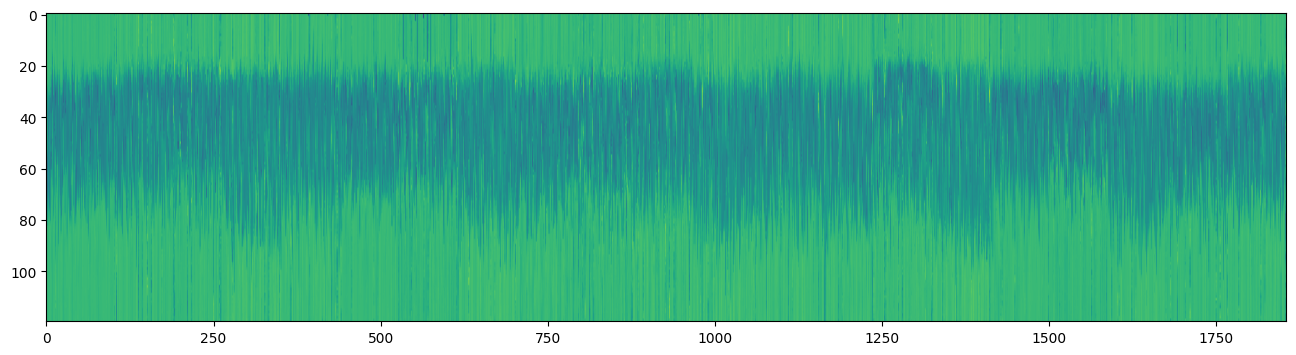

In [29]:
plt.figure(figsize=(16,4))
plt.imshow(clean_data[::4,::].T, aspect='auto')
plt.show()

In [30]:
from scipy.ndimage.interpolation import shift

aligned_data = []
for step_idx, sig in zip(first_step_idx, clean_data):
#     new_sig = np.roll(sig, 20-step_idx)
    new_sig = shift(sig, 20-step_idx, mode='reflect')
    
    aligned_data.append(new_sig)

aligned_data = np.array(aligned_data)  

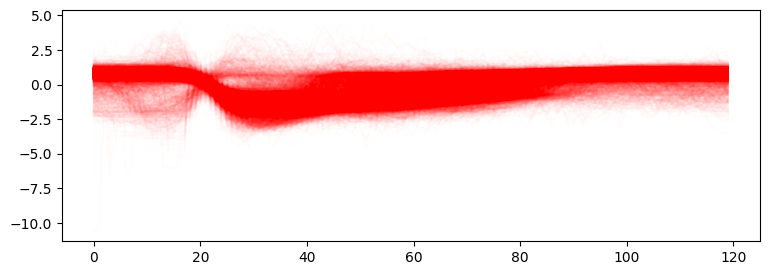

In [31]:
plt.figure(figsize=(9,3))
for sss in aligned_data:
    plt.plot(sss, color='r', alpha=0.01)
plt.show()

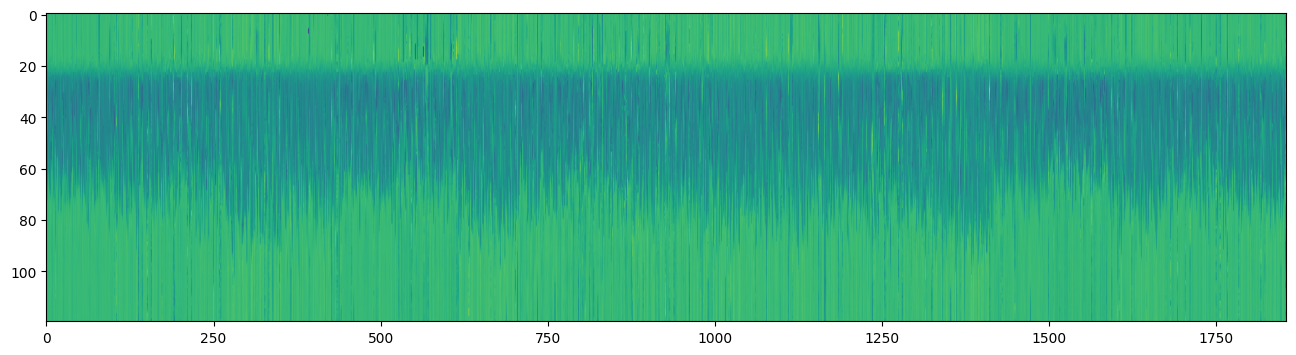

In [32]:
plt.figure(figsize=(16,4))
plt.imshow(aligned_data[::4,::].T, aspect='auto')
plt.show()

### Aligning

In [ ]:
data_full = mt_file['data']
labels_full = mt_file['labels']
data_full.shape

In [ ]:
clean_data_full = np.array(data_full)
clean_labels_full = np.array(labels_full)

In [ ]:
aligned_data_full = []
for step_idx, sig in zip(first_step_idx, clean_data_full):
    new_sig = np.roll(sig, shift=20-step_idx, axis=0)
#     new_sig = shift(sig, shift=np.array([20-step_idx,0]), mode='reflect')
    aligned_data_full.append(new_sig)

aligned_data_full = np.array(aligned_data_full) 

In [ ]:
aligned_data_full.shape

In [ ]:
data_check = np.mean(np.mean(aligned_data_full, axis=-1), axis=-1)
scaler = StandardScaler()
data_check = scaler.fit_transform(data_check.T).T

In [ ]:
plt.figure(figsize=(16,4))
plt.imshow(data_check[::4,::].T, aspect='auto')
plt.show()

### Saving aligned data

In [ ]:
mdic = {"labels": clean_labels_full, "data": aligned_data_full}

In [ ]:
savemat("data/ALIGNED_gestures_4d_full.mat", mdic)

### Saving non-aligned with start-stop

In [34]:
mdic_start_stop = {"labels": labels, 'starts':first_step_idx, 'stops':last_step_idx}

In [36]:
savemat("data/start_stop_4d_full.mat", mdic_start_stop)